In [ ]:
print('hello world')
import sys
sys.path.append('/home/s94zalek/shape_matching')

from datasets_code import build_dataloader, build_dataset
from utils.options import parse_options
from train import create_train_val_dataloader
import torch
import numpy as np

import os
os.chdir('/home/s94zalek/shape_matching')

# print current working directory
print(os.getcwd())

In [ ]:

# root_path = osp.abspath(osp.join(__file__, osp.pardir))
root_path = '/home/s94zalek/shape_matching'

opt = parse_options(root_path, is_train=False, use_argparse=False,
                    opt_path = 'options/train/faust.yaml')

opt['root_path'] = root_path
opt['dist'] = False

opt['datasets']['train_dataset']['return_corr'] = True
opt['datasets']['train_dataset']['return_dist'] = False
opt['datasets']['test_dataset']['return_dist'] = False

# create train and validation dataloaders
result = create_train_val_dataloader(opt)
train_loader, train_sampler, val_loader, total_epochs, total_iters = result
train_set = train_loader.dataset

test_set = build_dataset(opt['datasets']['test_dataset'])
test_loader = build_dataloader(
test_set, opt['datasets']['test_dataset'], phase='val', num_gpu=opt['num_gpu'], dist=opt['dist'], sampler=None, seed=opt['manual_seed'])


In [ ]:
data_x = train_set[12]['first']
data_y = train_set[12]['second']

Cxy = train_set[12]['Cxy']
Cyx = train_set[12]['Cyx']

phi_x = data_x['evecs']
phi_x_T = data_x['evecs_trans']
phi_y = data_y['evecs']
phi_y_T = data_y['evecs_trans']

In [ ]:
Pyx_after = phi_y @ Cxy @ phi_x_T
Pxy_after = phi_x @ Cyx @ phi_y_T

In [ ]:
import trimesh

scene = trimesh.Scene()

In [ ]:
#########################################
# X -> Y
#########################################

scene.geometry.clear()

cmap = trimesh.visual.color.interpolate(data_x['verts'][:, 1], 'jet')

# add the first mesh
mesh1 = trimesh.Trimesh(vertices=data_x['verts'].cpu().numpy(), faces=data_x['faces'].cpu().numpy())
mesh1.visual.vertex_colors = cmap[:len(mesh1.vertices)]
scene.add_geometry(mesh1)


mesh2 = trimesh.Trimesh(vertices=data_y['verts'].cpu().numpy() + np.array([1, 0, 0]), faces=data_y['faces'].cpu().numpy())

print(cmap.shape)

cmap2 = Pyx_after @ (cmap.astype(np.float32) / 255)

cmap2 = (torch.abs(cmap2).numpy() * 255).clip(0, 255).astype(np.uint8)

mesh2.visual.vertex_colors = cmap2[:len(mesh2.vertices)]
scene.add_geometry(mesh2)

scene.show()

# Using same functional map on 2 different poses of same shape

In [ ]:
data_y1 = train_set[13]['second']
data_y2 = train_set[14]['second']

phi_y1 = data_y1['evecs']
phi_y1_T = data_y1['evecs_trans']

phi_y2 = data_y2['evecs']
phi_y2_T = data_y2['evecs_trans']

In [ ]:
Py1x = phi_y1 @ Cxy @ phi_x_T
Py2x = phi_y2 @ Cxy @ phi_x_T

Pxy1 = phi_x @ Cyx @ phi_y1_T
Pxy2 = phi_x @ Cyx @ phi_y2_T

In [ ]:
#########################################
# X -> Y
#########################################

scene.geometry.clear()

cmap = trimesh.visual.color.interpolate(data_x['verts'][:, 1], 'jet')

# add the first mesh
mesh1 = trimesh.Trimesh(vertices=data_x['verts'].cpu().numpy(), faces=data_x['faces'].cpu().numpy())
mesh1.visual.vertex_colors = cmap[:len(mesh1.vertices)]
scene.add_geometry(mesh1)


mesh2 = trimesh.Trimesh(vertices=data_y['verts'].cpu().numpy() + np.array([1, 0, 0]), faces=data_y['faces'].cpu().numpy())

cmap2 = Pyx_after @ (cmap.astype(np.float32) / 255)
cmap2 = (torch.abs(cmap2).numpy() * 255).clip(0, 255).astype(np.uint8)

mesh2.visual.vertex_colors = cmap2[:len(mesh2.vertices)]
scene.add_geometry(mesh2)


mesh2 = trimesh.Trimesh(vertices=data_y1['verts'].cpu().numpy() + np.array([2, 0, 0]), faces=data_y1['faces'].cpu().numpy())

cmap2 = Py1x @ (cmap.astype(np.float32) / 255)
cmap2 = (torch.abs(cmap2).numpy() * 255).clip(0, 255).astype(np.uint8)

mesh2.visual.vertex_colors = cmap2[:len(mesh2.vertices)]
scene.add_geometry(mesh2)


mesh3 = trimesh.Trimesh(vertices=data_y2['verts'].cpu().numpy() + np.array([3, 0, 0]), faces=data_y2['faces'].cpu().numpy())

cmap3 = Py2x @ (cmap.astype(np.float32) / 255)
cmap3 = (torch.abs(cmap3).numpy() * 255).clip(0, 255).astype(np.uint8)

mesh3.visual.vertex_colors = cmap3[:len(mesh3.vertices)]
scene.add_geometry(mesh3)

scene.show()

# Hard correspondence

In [ ]:
from utils.fmap_util import nn_query, fmap2pointmap

p2p_yx = fmap2pointmap(Cxy, phi_x, phi_y)
p2p_xy = fmap2pointmap(Cyx, phi_y, phi_x)

p2p_y1x = fmap2pointmap(Cxy, phi_x, phi_y1)
p2p_xy1 = fmap2pointmap(Cyx, phi_y1, phi_x)

p2p_y2x = fmap2pointmap(Cxy, phi_x, phi_y2)
p2p_xy2 = fmap2pointmap(Cyx, phi_y2, phi_x)

In [ ]:
def index_with_P(tensor_to_index, P):
    # assert tensor_to_index.shape == P.shape, f'tensor_to_index.shape {tensor_to_index.shape} != P.shape {P.shape}'
    
    indexed_tensor = tensor_to_index[P]
    
    # replace values where P = -1 with zeros
    if type(indexed_tensor) == torch.Tensor:
        backend = torch 
    elif type(indexed_tensor) == np.ndarray:
        backend = np
    else:
        raise ValueError(f'Unknown type of indexed_tensor {type(indexed_tensor)}')
    
    indexed_tensor[P == -1] = backend.zeros_like(indexed_tensor[P == -1])
    return indexed_tensor
    

In [ ]:
#########################################
# X -> Y
#########################################

scene.geometry.clear()

cmap = trimesh.visual.color.interpolate(data_x['verts'][:, 1], 'jet')

# add the first mesh
mesh1 = trimesh.Trimesh(vertices=data_x['verts'].cpu().numpy(), faces=data_x['faces'].cpu().numpy())
mesh1.visual.vertex_colors = cmap[:len(mesh1.vertices)]
scene.add_geometry(mesh1)


mesh2 = trimesh.Trimesh(vertices=data_y['verts'].cpu().numpy() + np.array([1, 0, 0]), faces=data_y['faces'].cpu().numpy())
cmap2 = index_with_P(cmap, p2p_yx)[:len(mesh2.vertices)]

mesh2.visual.vertex_colors = cmap2[:len(mesh2.vertices)]
scene.add_geometry(mesh2)


mesh3 = trimesh.Trimesh(vertices=data_y1['verts'].cpu().numpy() + np.array([2, 0, 0]), faces=data_y1['faces'].cpu().numpy())
cmap3 = index_with_P(cmap, p2p_y1x)[:len(mesh3.vertices)]

mesh3.visual.vertex_colors = cmap3[:len(mesh3.vertices)]
scene.add_geometry(mesh3)


mesh4 = trimesh.Trimesh(vertices=data_y2['verts'].cpu().numpy() + np.array([3, 0, 0]), faces=data_y2['faces'].cpu().numpy())
cmap4 = index_with_P(cmap, p2p_y2x)[:len(mesh4.vertices)]

mesh4.visual.vertex_colors = cmap4[:len(mesh4.vertices)]
scene.add_geometry(mesh4)

scene.show()

# Compare functional maps for different poses

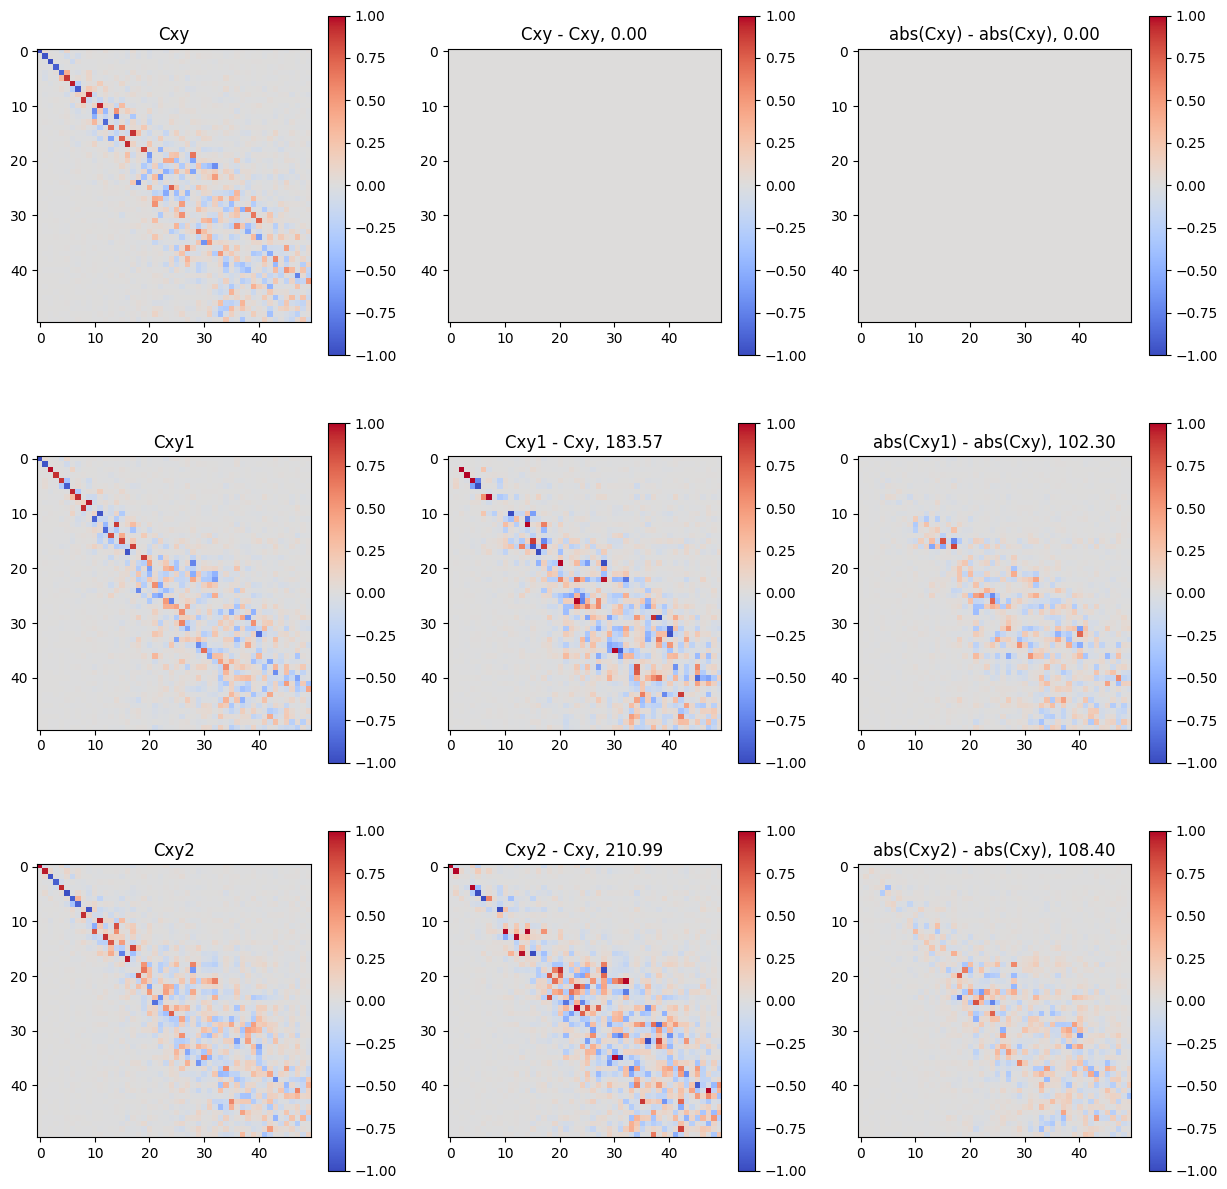

In [86]:
import matplotlib.pyplot as plt

Cxy = train_set[12]['Cxy'][:50, :50].cpu().numpy()
Cxy1 = train_set[13]['Cxy'][:50, :50].cpu().numpy()
Cxy2 = train_set[14]['Cxy'][:50, :50].cpu().numpy()

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i, (C_map, title) in enumerate(zip([Cxy, Cxy1, Cxy2], ['Cxy', 'Cxy1', 'Cxy2'])):
    plt_0 = ax[i, 0].imshow(C_map, vmin=-1, vmax=1, cmap='coolwarm')
    ax[i, 0].set_title(title)
    
    diff = C_map - Cxy
    
    plt_1 = ax[i, 1].imshow(diff, vmin=-1, vmax=1, cmap='coolwarm')
    ax[i, 1].set_title(f'{title} - Cxy, {np.abs(diff).sum():.2f}')
    
    diff_abs = np.abs(C_map) - np.abs(Cxy)
    
    plt_2 = ax[i, 2].imshow(diff_abs, vmin=-1, vmax=1, cmap='coolwarm')
    ax[i, 2].set_title(f'abs({title}) - abs(Cxy), {np.abs(diff_abs).sum():.2f}')
    
    # plot colorbar
    fig.colorbar(plt_0, ax=ax[i, 0])
    fig.colorbar(plt_1, ax=ax[i, 1])
    fig.colorbar(plt_2, ax=ax[i, 2])
    
plt.show()

# Plot LB eigenvalues

In [49]:
eigenvalues = []

for i in range(80):
    data = train_set[i]
    data_y = data['second']
    
    eigenvalues.append(data_y['evals'])
    
eigenvalues = torch.stack(eigenvalues, dim=0)
print('eigenvalues.shape', eigenvalues.shape)

eigenvalues.shape torch.Size([80, 200])


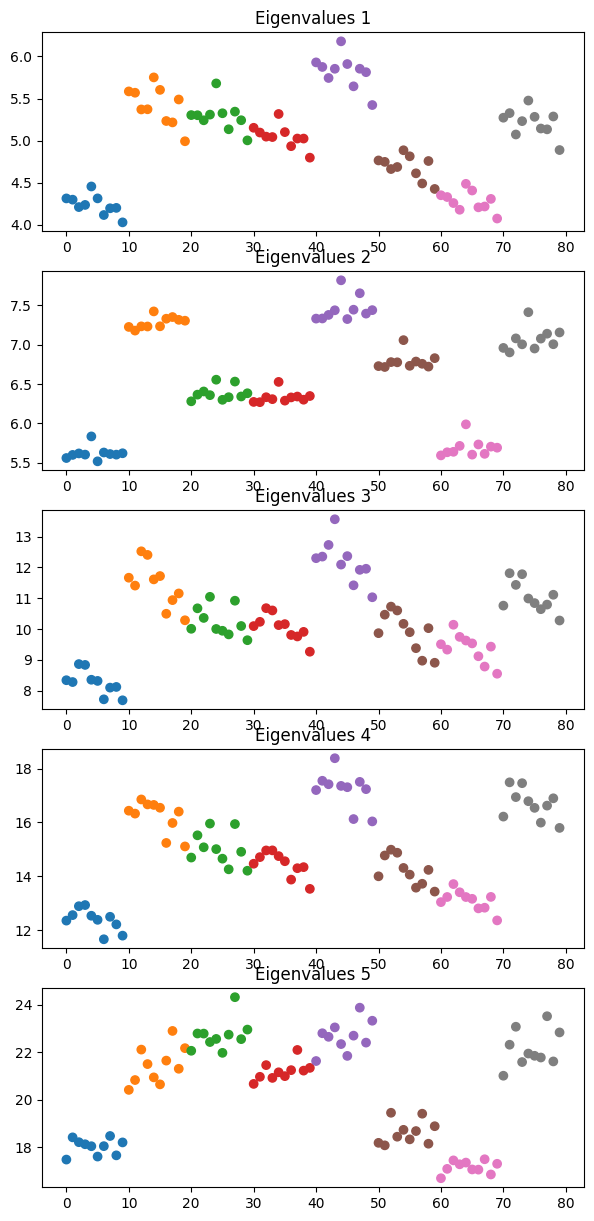

In [73]:
# plot eigenvalues

import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 1, figsize=(7, 15))

color_index = [i // 10 for i in range(80)]
colors = plt.cm.tab10(color_index)

for i in range(5):
    # color each value based on the index
    ax[i].scatter(range(80), eigenvalues[:, i + 1], c=colors)
    
    # for j in range(80):
    #     ax[i].plot(j, eigenvalues[:j], c=colors[j], marker='o')
        
    ax[i].set_title(f'Eigenvalues {i + 1}')
    
plt.show()

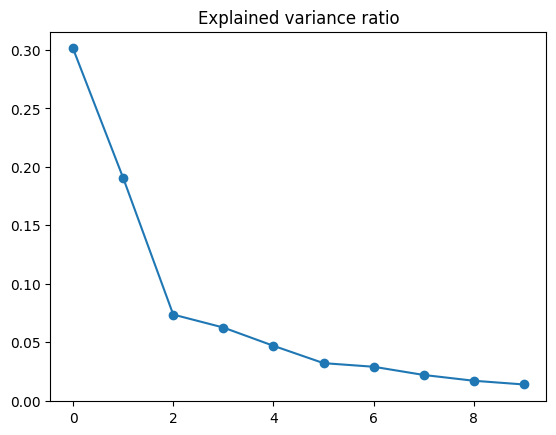

In [91]:
# apply PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

pca = PCA(n_components=10)
scaler = StandardScaler()

eigenvalues_scaled = scaler.fit_transform(eigenvalues)
eigenvalues_pca = pca.fit_transform(eigenvalues_scaled)

# plot the explained variance 

plt.plot(pca.explained_variance_ratio_, 'o-')
plt.title('Explained variance ratio')
plt.show()

In [96]:
pd.DataFrame(eigenvalues_pca, columns=[f'PCA_{i}' for i in range(10)]).head()

KeyError: (slice(None, None, None), slice(None, 5, None))

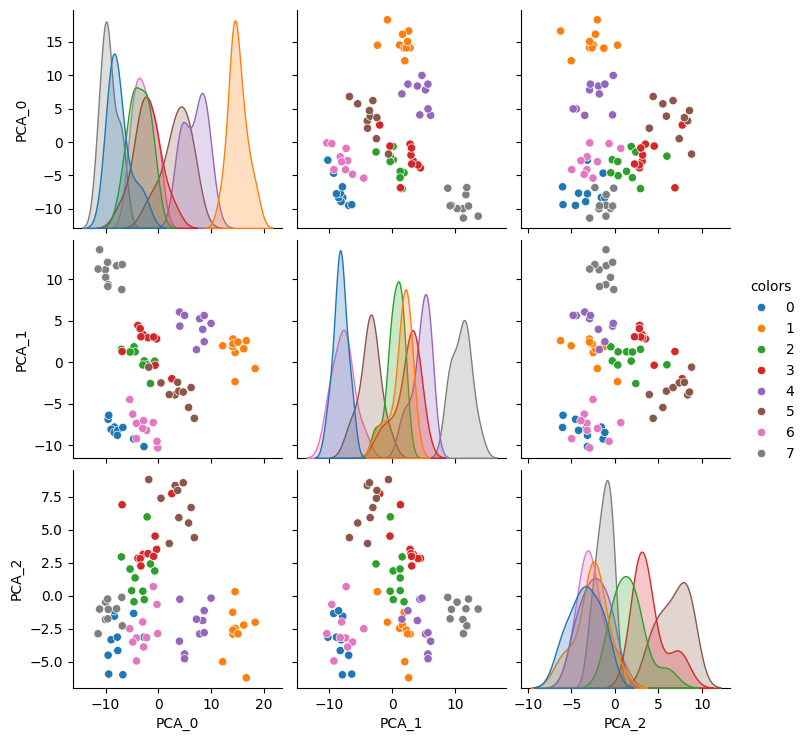

In [105]:
import pandas as pd

eigenvalues_pca_df = pd.DataFrame(eigenvalues_pca[:, :3], columns=[f'PCA_{i}' for i in range(3)])
eigenvalues_pca_df['colors'] = color_index

sns.pairplot(
    eigenvalues_pca_df,
    hue='colors',
    palette='tab10',
    diag_kind='kde',
)
plt.show()